# Code

In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import numpy as np
import pickle
import math
import torch
from tqdm.notebook import tqdm
import seaborn as sns
from torch.utils.data import DataLoader
# if its_jupyter_notebook:
#     sys.argv = [''] #Remove this if it's not a jupyter notebook!

import sys
sys.path.insert(0, '..')

%load_ext autoreload
%autoreload 2
from dataset.data import (
    RNADataset,
    RNADatasetNT,
    EasyPosAugment,
    InteractionSelectionPolicy,
    EasyNegAugment,
    HardPosAugment,
    HardNegAugment,
    SmartNegAugment,
    plot_sample,
    #plot_sample2,
    seed_everything,
)
from config import *

In [3]:
df_genes = pd.read_csv(os.path.join(processed_files_dir, "df_genes.csv"))
df = pd.read_csv(os.path.join(processed_files_dir, "final_df.csv"))

In [5]:
#the N in the cdna creates problem with the tokenizer
df_genes['problematic_set'] = df_genes['cdna'].apply(lambda x: False if (set(x) - set({'A', 'C', 'G', 'T'}) == set()) else True)
genesN = set(df_genes[df_genes.problematic_set].gene_id.values)
print(f'{len(genesN)} genes have N, so will be excluded')
df = df[~(df.gene1.isin(genesN))|(df.gene2.isin(genesN))].reset_index(drop = True)

2 genes have N, so will be excluded


In [5]:
with open(os.path.join(rna_rna_files_dir, f"gene_pairs_training.txt"), "rb") as fp:  # Unpickling
    subset_train = pickle.load(fp)
    subset_train_series = pd.Series(subset_train).str.split('_', expand = True)
    genes_train = set(subset_train_series[0]).union(set(subset_train_series[1]))
    
with open(os.path.join(rna_rna_files_dir, f"gene_pairs_test.txt"), "rb") as fp:  # Unpickling
    subset_test = pickle.load(fp)

In [45]:
df_int = df[df.interacting]

In [46]:
df_interactions = pd.concat([
    df_int[['gene1', 'length_1', 'x1', 'w']].rename({'gene1':'gene', 'length_1':'length', 'x1': 'x1', 'w': 'w'}, axis = 1),
    df_int[['gene2', 'length_2', 'y1', 'h']].rename({'gene2':'gene', 'length_2':'length', 'y1': 'x1', 'h': 'w'}, axis = 1)
], axis = 0)
df_interactions = df_interactions.drop_duplicates()

the mean is 3.75059607804973
the median is 2.0


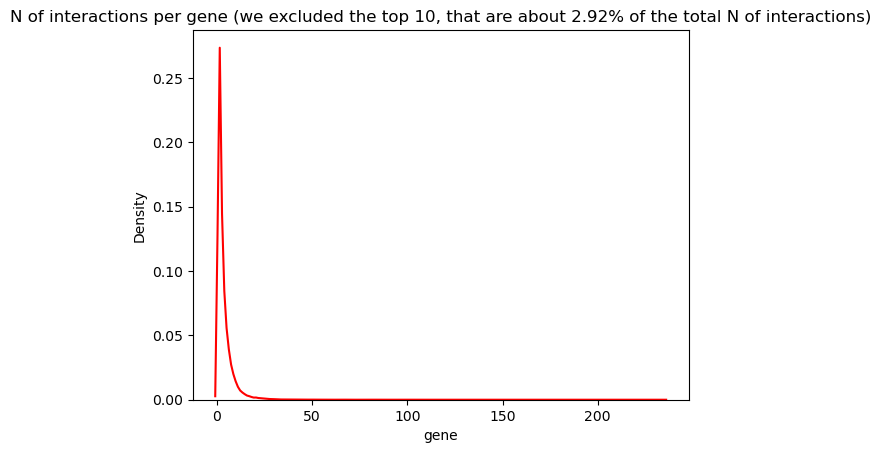

In [47]:
print(f'the mean is {np.mean(df_interactions.gene.value_counts())}')
print(f'the median is {np.median(df_interactions.gene.value_counts())}')

n_to_exclude = 10

sns.kdeplot(df_interactions.gene.value_counts()[n_to_exclude:], color = 'red')

perc_excluded_from_plot = np.round(df_interactions.gene.value_counts()[:n_to_exclude].sum()/df_interactions.shape[0] * 100, 2)

plt.title(f'N of interactions per gene (we excluded the top {n_to_exclude}, that are about {perc_excluded_from_plot}% of the total N of interactions)')
plt.show()

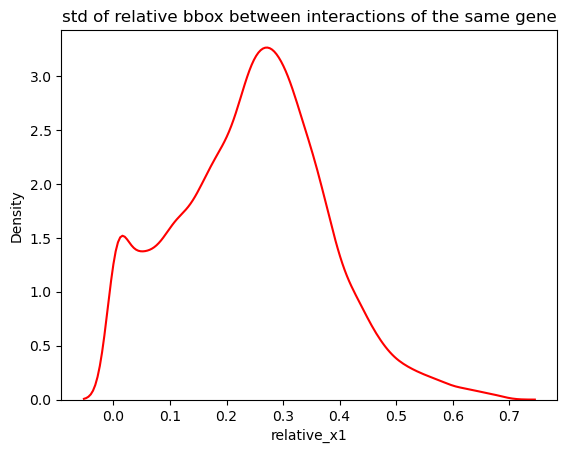

In [48]:
df_interactions['relative_x1'] = df_interactions.x1/df_interactions.length
sns.kdeplot(df_interactions.groupby('gene').std().relative_x1, color = 'red')
plt.title(f'std of relative bbox between interactions of the same gene')
plt.show()

In [49]:
df_interactions = df_interactions.merge(df_genes[['gene_id', 'cdna']].rename({'gene_id':'gene'}, axis = 1))
df_interactions['id'] = df_interactions.reset_index(drop = True).index

In [50]:
def get_cdna_slices(x):
    cdna, x1, w, length = x['cdna'], x['x1'], x['w'], x['length']
    random_x1 = np.random.randint(0, length - w)
    cdna_slice = cdna[x1:(x1 + w)]
    random_cdna_slice = cdna[random_x1:(random_x1 + w)]
    assert len(cdna_slice) == len(random_cdna_slice) == w
    return pd.Series([random_x1, cdna_slice, random_cdna_slice])

df_interactions[['random_x1', 'interacting_slice', 'random_slice']] = df_interactions.apply(get_cdna_slices, axis=1)

df_interactions = df_interactions.drop(['cdna', 'relative_x1'], axis = 1)

In [51]:
list_files = os.listdir(os.path.join(embedding_dir, '32'))

embedding_files = pd.DataFrame(list_files).rename({0:'filename'}, axis = 1)

new_cols = embedding_files.filename.str.extractall('(.*)_(.*)_(.*)(.npy)').reset_index(drop = True)

embedding_files = pd.concat([
    new_cols.rename({0:'gene', 1:'c1', 2:'c2'}, axis = 1).drop(3, axis = 1), 
    embedding_files
], axis = 1)

In [52]:
def create_df_embedding_query(df):
    df['c1'] = df['c1'].astype(int)
    df['c2'] = df['c2'].astype(int)

    #drop the embeddings that doesnt contain the sequence
    df = df[
        (df.x1 >= df.c1) & ((df.x1 + df.w) <= df.c2)
    ]

    # keep the one that brings x1 at the center of the sequence
    df['c_mean'] = (df['c1'] +  df['c2'])/2
    df['diff'] = abs(df['x1'] - df['c_mean'])
    df = df.sort_values('diff').drop_duplicates(['gene', 'x1', 'w'], keep = 'first')
    return df

df_real_embeddings = create_df_embedding_query(
    df_interactions[['gene', 'length', 'x1', 'w']].merge(embedding_files)
).rename(
    {'filename':'filename_x1'}, axis = 1
)

df_fake_embeddings = create_df_embedding_query(
    df_interactions[['gene', 'length', 'random_x1', 'w']].rename(
        {'random_x1':'x1'}, axis = 1).merge(embedding_files)
).rename(
    {'x1':'random_x1', 'filename':'filename_random_x1', 'c1':'c1_random', 'c2':'c2_random'}, axis = 1
)

/tmp/ipykernel_273147/2968836023.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c_mean'] = (df['c1'] +  df['c2'])/2
/tmp/ipykernel_273147/2968836023.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff'] = abs(df['x1'] - df['c_mean'])
/tmp/ipykernel_273147/2968836023.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [53]:
assert df_real_embeddings.shape[0] == df_interactions.shape[0]
assert set(df_interactions.gene) - set(df_real_embeddings.gene) == set()

In [54]:
print('Embeddings were already calculated. The random coordinates may cause the loose of some sequences')

print('I will lose this # of sequences for this analysis: ', df_interactions.shape[0] - df_fake_embeddings.shape[0])

print('I will lose this # of genes for this analysis: ', len(set(df_interactions.gene) - set(df_fake_embeddings.gene)))

Embeddings were already calculated. The random coordinates may cause the loose of some sequences
I will lose this # of sequences for this analysis:  348
I will lose this # of genes for this analysis:  37


In [56]:
df_real_embeddings = df_real_embeddings[['gene', 'x1', 'w', 'filename_x1', 'c1', 'c2']]
df_fake_embeddings = df_fake_embeddings[['gene', 'random_x1', 'w', 'filename_random_x1', 'c1_random', 'c2_random']]

df_interactions = df_interactions.merge(df_real_embeddings, on = ['gene', 'x1', 'w'])
df_interactions = df_interactions.merge(df_fake_embeddings, on = ['gene', 'random_x1', 'w'])

Lets now download the embeddings

In [118]:
genes_to_load = list(set(df_interactions.filename_x1).union(df_interactions.filename_random_x1))

In [119]:
len(genes_to_load)

70233

In [142]:
embedding_data = []
for gene_to_load in tqdm(genes_to_load):
    embedding = np.load(os.path.join(embedding_dir, '32', f'{gene_to_load}'))

    subset_real = df_interactions[df_interactions.filename_x1 == gene_to_load]
    subset_fake = df_interactions[df_interactions.filename_random_x1 == gene_to_load]

    for _, row in subset_real.iterrows():
        x1, w, c1, c2 = row.x1, row.w, row.c1 , row.c2
        coordx1 = (x1-c1) // 6
        coordx2 = math.ceil( ((x1+w) - c1 ) / 6 )
        assert (w - (coordx2-coordx1)*6) <= 12
        embedding_slice=np.mean(embedding[coordx1:coordx2], axis = 0)
        embedding_name = str(row.id) + 'real.npy'
        np.save(os.path.join(processed_files_dir, 'similarity_analysis', 'embeddings', embedding_name), embedding_slice)
        embedding_data.append({'filename':gene_to_load, 'x1':x1, 'w': w, 'embedding_name':embedding_name})

    for _, row in subset_fake.iterrows():
        x1, w, c1, c2 = row.random_x1, row.w, row.c1_random , row.c2_random
        coordx1 = (x1-c1) // 6
        coordx2 = math.ceil( ((x1+w) - c1 ) / 6 )
        assert (w - (coordx2-coordx1)*6) <= 12
        embedding_slice=np.mean(embedding[coordx1:coordx2], axis = 0)
        embedding_name = str(row.id) + 'random.npy'
        np.save(os.path.join(processed_files_dir, 'similarity_analysis', 'embeddings', embedding_name), embedding_slice)
        embedding_data.append({'filename':gene_to_load, 'x1':x1, 'w': w, 'embedding_name':embedding_name})
embedding_data = pd.DataFrame(embedding_data)

  0%|          | 0/70233 [00:00<?, ?it/s]

In [143]:
real = df_interactions.merge(embedding_data, left_on = ['filename_x1', 'x1', 'w'], right_on = ['filename', 'x1', 'w'])
real = real.drop(['c1_random', 'c2_random', 'filename_x1', 'filename_random_x1', 'filename', 'c1', 'c2'], axis = 1)

In [144]:
fake = df_interactions.merge(embedding_data, left_on = ['filename_random_x1', 'random_x1', 'w'], right_on = ['filename', 'x1', 'w'])
fake = fake.rename({'x1_x':'x1'}, axis = 1).drop(['x1_y', 'c1_random', 'c2_random', 'filename_x1', 'filename_random_x1', 'filename', 'c1', 'c2'], axis = 1)


In [17]:
realfake = pd.concat([real, fake], axis = 0)
realfake = realfake.drop('embedding_name', axis = 1).drop_duplicates()
assert realfake.shape[0] == df_interactions.shape[0]
assert set(realfake.id) == set(df_interactions.id)

In [18]:
realfake.to_csv(os.path.join(processed_files_dir, 'similarity_analysis', 'fakereal.csv'), index = False)

In [24]:
df_interactions['filename_real'] = df_interactions.id.astype(str) + 'real.npy'
df_interactions['filename_random'] = df_interactions.id.astype(str) + 'random.npy'

In [79]:
df_interactions = df_interactions.merge(
    df_genes[['gene_id', 'gene_type_set', 'species_set', 'method', 'protein_coding']].rename({'gene_id': 'gene'}, axis = 1),
    on ='gene'
)

In [80]:
df_interactions.to_csv(os.path.join(processed_files_dir, 'similarity_analysis', 'df_interactions.csv'), index = False)

# Analysis 

In [3]:
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.decomposition import PCA

In [4]:
with open(os.path.join(rna_rna_files_dir, f"gene_pairs_training.txt"), "rb") as fp:  # Unpickling
    subset_train = pickle.load(fp)
    subset_train_series = pd.Series(subset_train).str.split('_', expand = True)
    genes_train = set(subset_train_series[0]).union(set(subset_train_series[1]))
    
with open(os.path.join(rna_rna_files_dir, f"gene_pairs_test.txt"), "rb") as fp:  # Unpickling
    subset_test = pickle.load(fp)
    subset_test_series = pd.Series(subset_test).str.split('_', expand = True)
    genes_test = set(subset_test_series[0]).union(set(subset_test_series[1]))
    
with open(os.path.join(rna_rna_files_dir, f"gene_pairs_val.txt"), "rb") as fp:  # Unpickling
    subset_val = pickle.load(fp)
    subset_val_series = pd.Series(subset_val).str.split('_', expand = True)
    genes_val = set(subset_val_series[0]).union(set(subset_val_series[1]))

In [43]:
df_interactions = pd.read_csv(os.path.join(processed_files_dir, 'similarity_analysis', 'df_interactions.csv'))

In [45]:
df_valentino = df_interactions.drop(['filename_x1', 'c1', 'c2', 'filename_random_x1', 'c1_random', 'c2_random'], axis =1)

In [49]:
df_valentino.to_csv(os.path.join(processed_files_dir, 'similarity_analysis', 'df_valentino.csv'), index = False)

In [51]:
with open(os.path.join(processed_files_dir, 'similarity_analysis', f"genes_training.txt"), "wb") as fp:  # Unpickling
    pickle.dump(genes_train, fp)

with open(os.path.join(processed_files_dir, 'similarity_analysis', f"genes_test.txt"), "wb") as fp:  # Unpickling
    pickle.dump(genes_test, fp)
    
with open(os.path.join(processed_files_dir, 'similarity_analysis', f"genes_val.txt"), "wb") as fp:  # Unpickling
    pickle.dump(genes_val, fp)

In [6]:
genes_only_test = genes_test - genes_train

In [7]:
len(genes_only_test)

2466

In [8]:
n_samples = 10_000

In [40]:
def get_size(file_path, unit='bytes'):
    file_size = os.path.getsize(file_path)
    exponents_map = {'bytes': 0, 'kb': 1, 'mb': 2, 'gb': 3}
    if unit not in exponents_map:
        raise ValueError("Must select from \
        ['bytes', 'kb', 'mb', 'gb']")
    else:
        size = file_size / 1024 ** exponents_map[unit]
        return round(size, 3)


print(get_size(os.path.join(processed_files_dir, 'similarity_analysis', 'embeddings'), 'gb'))

0.012


In [41]:
os.path.join(processed_files_dir, 'similarity_analysis', 'embeddings')

'/data01/giorgio/RNARNA-NT/dataset/processed_files/similarity_analysis/embeddings'

In [9]:
train = df_interactions[df_interactions.gene.isin(genes_train)]

In [10]:
train_subset = train.sample(n_samples)

train_subset_0 = train_subset[
    ['gene', 'id', 'filename_real', 'gene_type_set', 'species_set', 'method', 'protein_coding']
].rename({'filename_real':'filename'}, axis = 1)

train_subset_1 = train_subset[
    ['gene', 'id', 'filename_random', 'gene_type_set', 'species_set', 'method', 'protein_coding']
].rename({'filename_random':'filename'}, axis = 1)

train_subset_1['interacting'] = 1 
train_subset_0['interacting'] = 0

train_subset = pd.concat([train_subset_0, train_subset_1], axis = 0)

In [11]:
X = []
for _, row in tqdm(train_subset.iterrows(), total = n_samples*2):
    if row.interacting == 1:
        embedding = np.load(os.path.join(processed_files_dir, 'similarity_analysis', 'embeddings', f'{row.filename}'))
        X.append(np.expand_dims(embedding, 0))
    else:
        embedding = np.load(os.path.join(processed_files_dir, 'similarity_analysis', 'embeddings', f'{row.filename}'))
        X.append(np.expand_dims(embedding, 0))

  0%|          | 0/20000 [00:00<?, ?it/s]

In [12]:
X = np.concatenate(X, axis = 0)

In [13]:
X_emb = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=30).fit_transform(X)

In [14]:
pca = PCA(n_components=3)
pca.fit(X)
X_pca = pca.transform(X)
print(pca.explained_variance_ratio_)

[0.12040652 0.06669933 0.05245956]


In [15]:
train_subset['TSNE-one'] = X_emb[:,0]
train_subset['TSNE-two'] = X_emb[:,1] 
train_subset['TSNE-three'] = X_emb[:,2]

train_subset['PCA-one'] = X_pca[:,0]
train_subset['PCA-two'] = X_pca[:,1] 
train_subset['PCA-three'] = X_pca[:,2]

/tmp/ipykernel_277261/2947196796.py:2: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


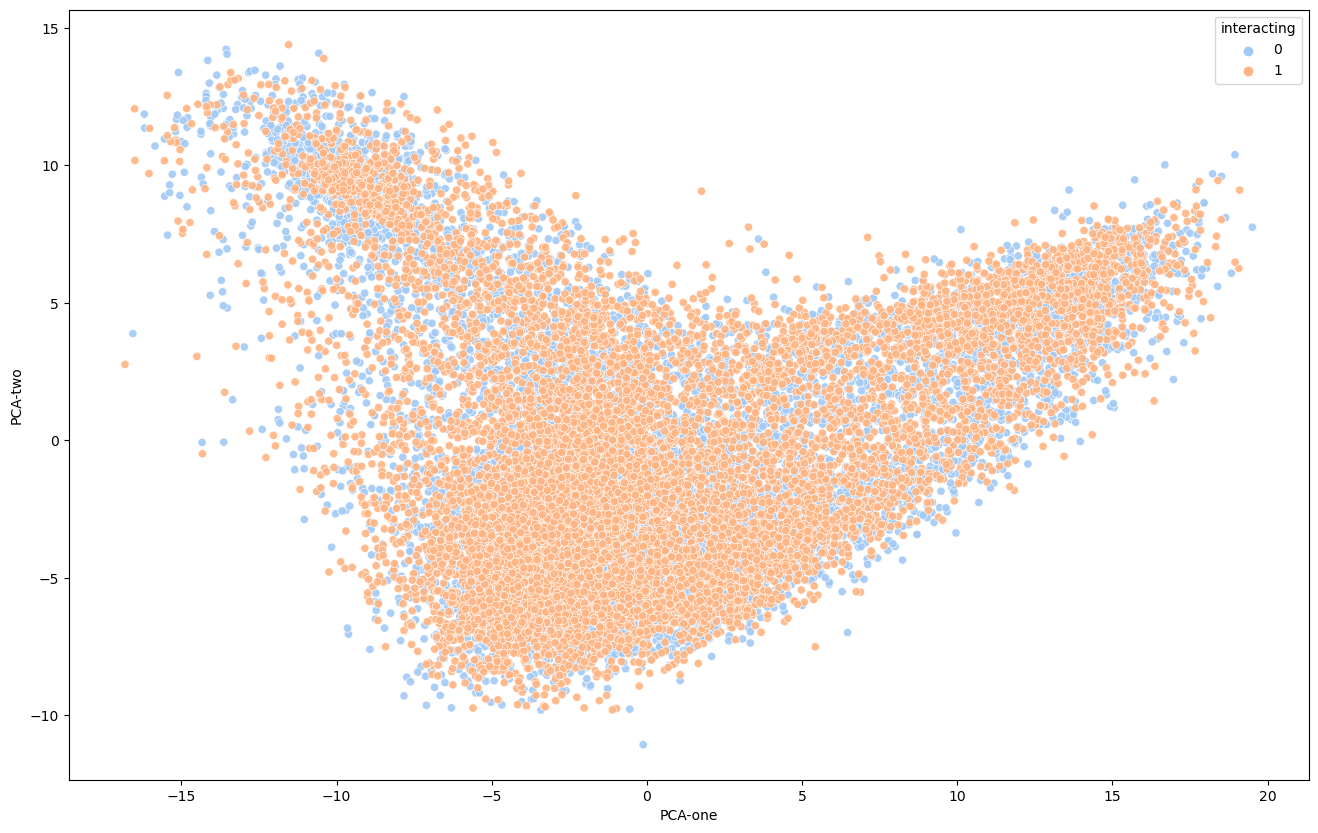

/tmp/ipykernel_277261/2947196796.py:12: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


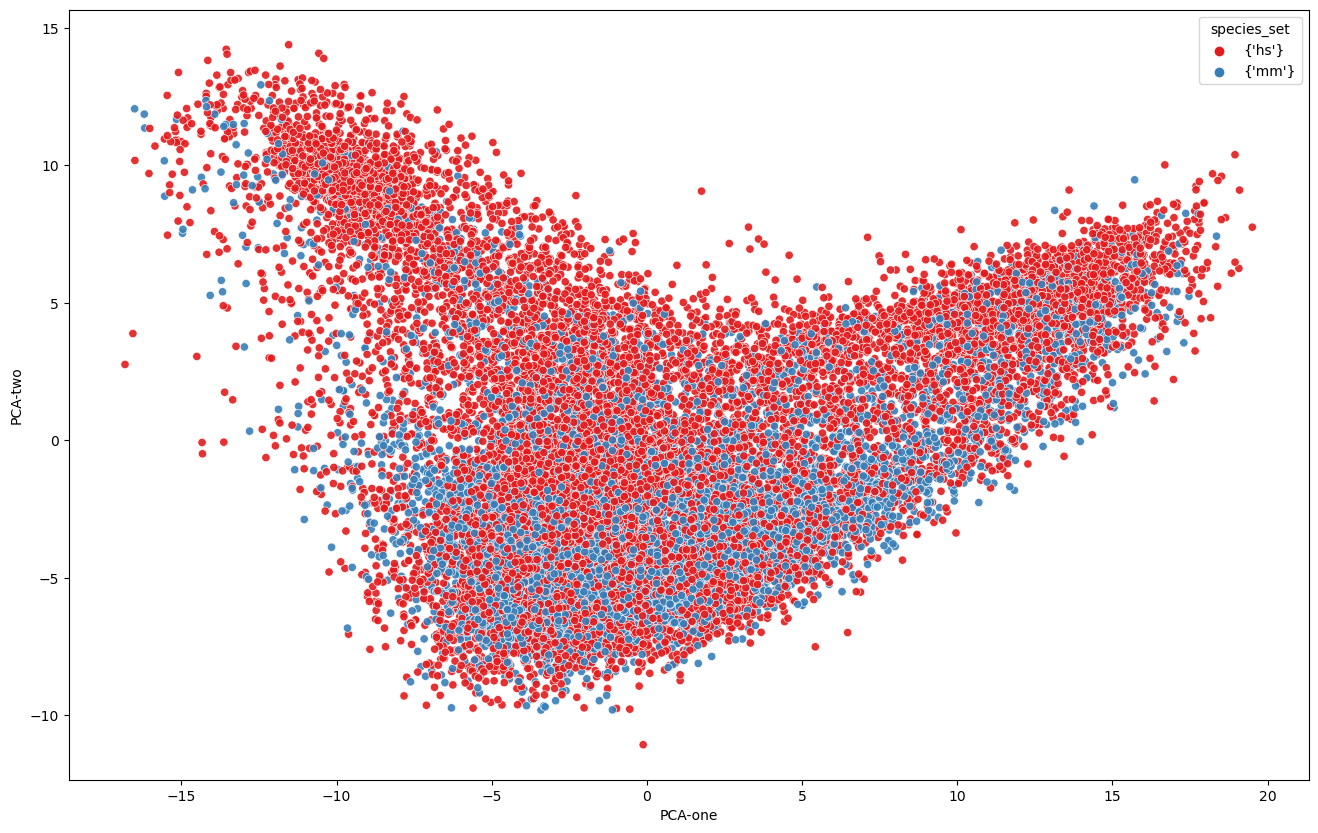

/tmp/ipykernel_277261/2947196796.py:22: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


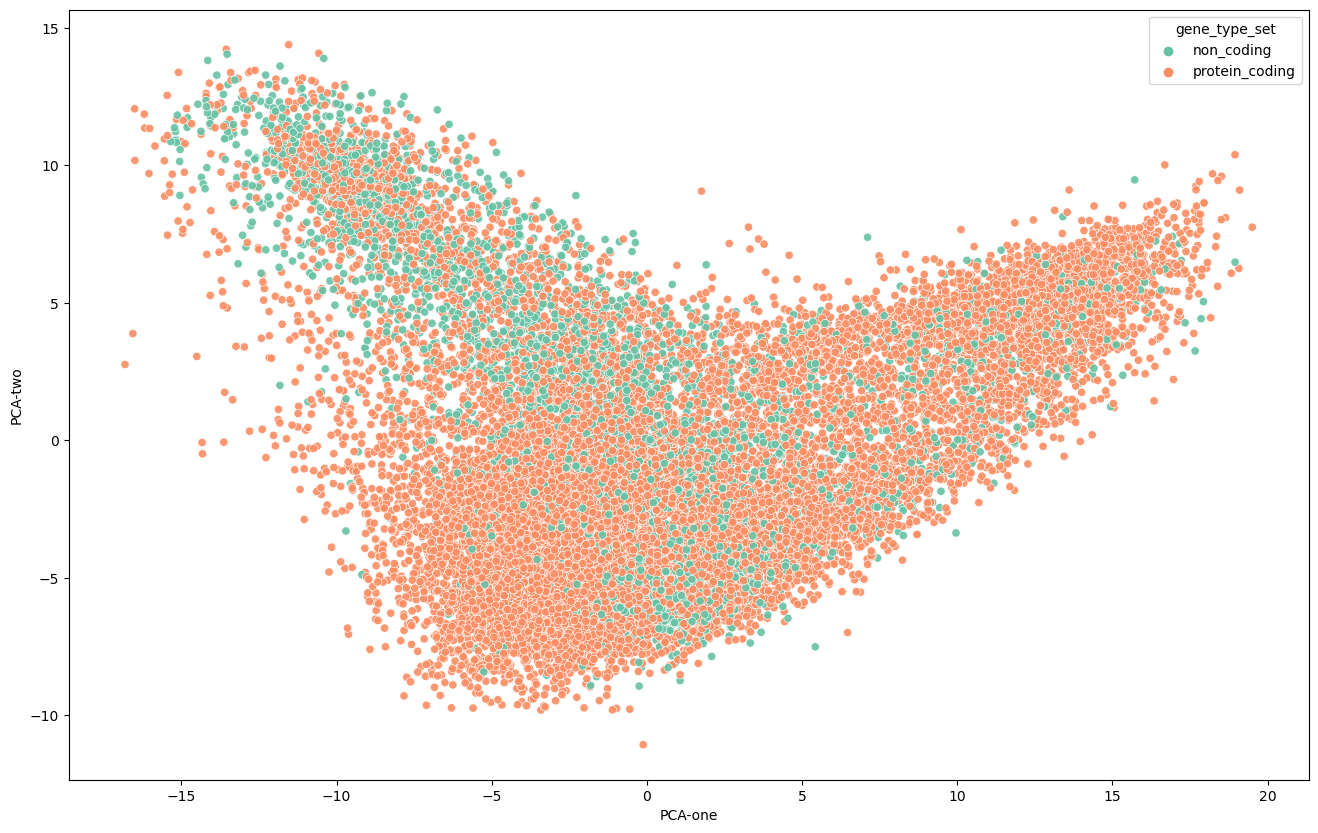

/tmp/ipykernel_277261/2947196796.py:33: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(


<Axes: xlabel='PCA-one', ylabel='PCA-two'>

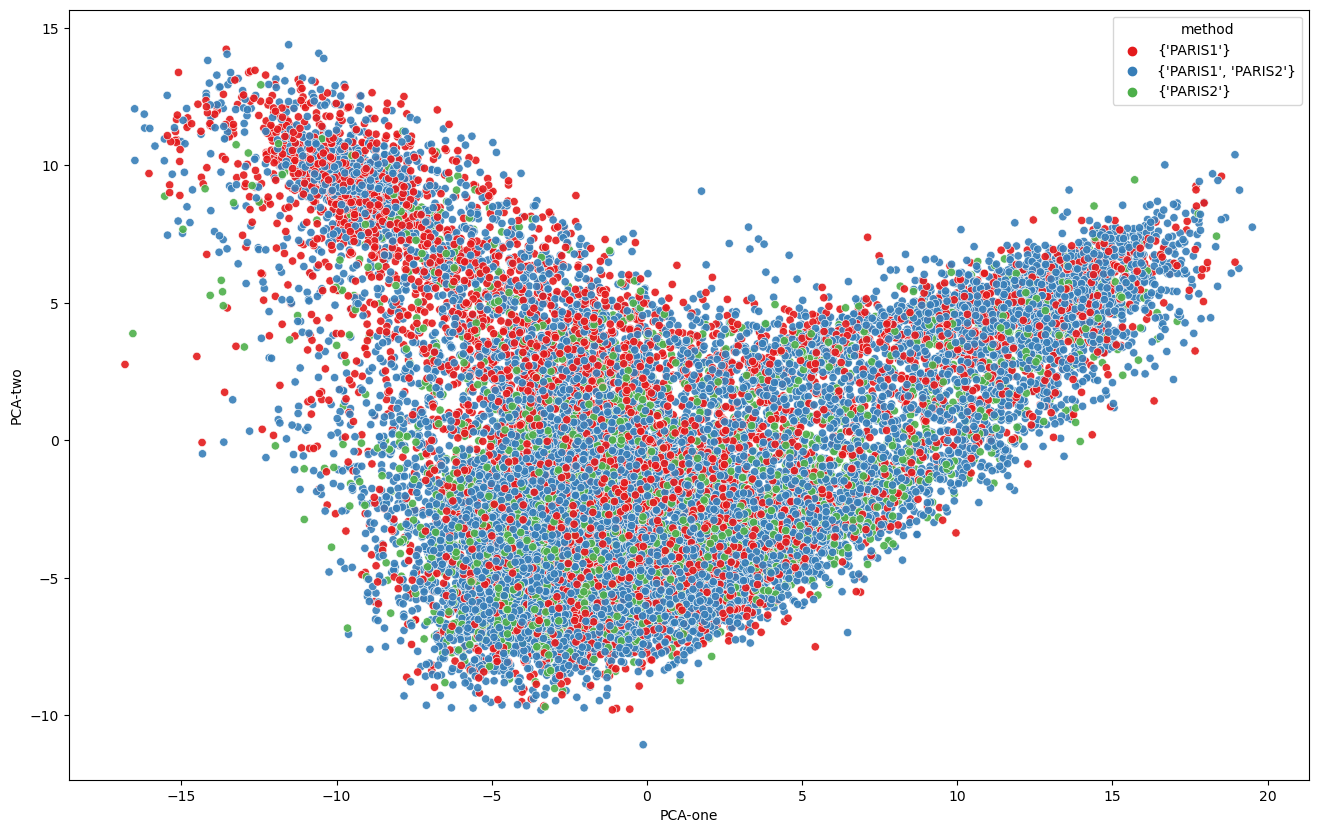

In [16]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="PCA-one", y="PCA-two",
    hue="interacting",
    palette=sns.color_palette("pastel", 10),
    data=train_subset,
    legend="full",
    alpha=0.9
)
plt.show()
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="PCA-one", y="PCA-two",
    hue="species_set",
    palette=sns.color_palette("Set1", 10),
    data=train_subset,
    legend="full",
    alpha=0.9
)
plt.show()
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="PCA-one", y="PCA-two",
    hue="gene_type_set",
    palette=sns.color_palette("Set2", 10),
    data=train_subset,
    legend="full",
    alpha=0.9
)

plt.show()
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="PCA-one", y="PCA-two",
    hue="method",
    palette=sns.color_palette("Set1", 10),
    data=train_subset,
    legend="full",
    alpha=0.9
)

In [26]:
# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="TSNE-one", y="TSNE-two",
#     hue="interacting",
#     palette=sns.color_palette("pastel", 10),
#     data=train_subset,
#     legend="full",
#     alpha=0.9
# )
# plt.show()
# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="TSNE-one", y="TSNE-two",
#     hue="species_set",
#     palette=sns.color_palette("Set1", 10),
#     data=train_subset,
#     legend="full",
#     alpha=0.9
# )
# plt.show()
# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="TSNE-one", y="TSNE-two",
#     hue="gene_type_set",
#     palette=sns.color_palette("Set2", 10),
#     data=train_subset,
#     legend="full",
#     alpha=0.9
# )

# plt.show()
# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="TSNE-one", y="TSNE-two",
#     hue="method",
#     palette=sns.color_palette("Set1", 10),
#     data=train_subset,
#     legend="full",
#     alpha=0.9
# )

In [33]:
from mpl_toolkits import mplot3d

%matplotlib notebook
ax.scatter3D(train_subset[train_subset.interacting== 1]["PCA-one"],
             train_subset[train_subset.interacting== 1]["PCA-two"],
             train_subset[train_subset.interacting== 1]["PCA-three"],
             s=50, color='red')

In [34]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    xs=train_subset["PCA-one"], 
    ys=train_subset["PCA-two"], 
    zs=train_subset["PCA-three"], 
    c=train_subset["interacting"], 
    cmap='tab10'
)
# Set the viewing angle
ax.view_init(elev=30, azim=45)  # Adjust the elevation and azimuth angles as needed

plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    xs=train_subset["PCA-one"], 
    ys=train_subset["PCA-two"], 
    zs=train_subset["PCA-three"], 
    c=train_subset["species_set"].apply(lambda x: 1 if x == "{'mm'}" else 0), 
    cmap='tab10'
)
# Set the viewing angle
ax.view_init(elev=30, azim=45)  # Adjust the elevation and azimuth angles as needed

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

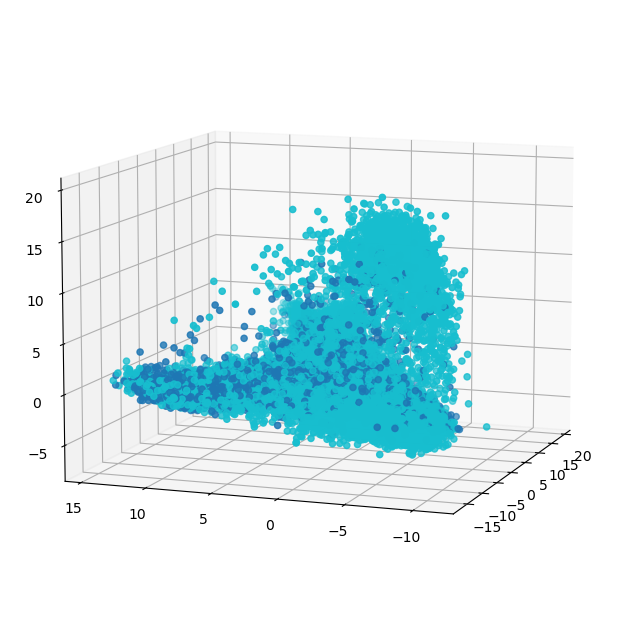

In [32]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    xs=train_subset["PCA-one"], 
    ys=train_subset["PCA-two"], 
    zs=train_subset["PCA-three"], 
    c=train_subset["gene_type_set"].apply(lambda x: 1 if x == "protein_coding" else 0), 
    cmap='tab10'
)
# Set the viewing angle
ax.view_init(elev=10, azim=200)  # Adjust the elevation and azimuth angles as needed

plt.show()

In [31]:
# fig = px.scatter_3d(
#     X[:10], x=0, y=1, z=2,
#     color=train_subset["interacting"].head(10), labels={'color': 'interacting'}
# )
# #fig.update_traces(marker_size=8)
# fig.show()